In [1]:
!pip install konlpy
!pip install mglearn
!pip install gluonnlp
!pip install mxnet

In [2]:
!pip install transformers==2.4.1

In [1]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.cluster import KMeans
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import mglearn
from sklearn.cluster import AgglomerativeClustering
import sys
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import random

In [9]:
!gdown --id 1CKmd6EheRX_o1_wHm32GoHMQlUkxTD3E

/Users/seokyoung/anaconda3/envs/test/lib/python3.8/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1CKmd6EheRX_o1_wHm32GoHMQlUkxTD3E
To: /Users/seokyoung/Desktop/PY202309-P/Sources/JAM.csv
100%|██████████████████████████████████████| 8.12M/8.12M [00:03<00:00, 2.41MB/s]


In [3]:
data = pd.read_csv("JAM.csv", engine='python',encoding='CP949')

## 데이터 분석

In [4]:
train_data = pd.DataFrame(data)

In [5]:
train_data.head(3) # 데이터 구성요소

,년도,가수,제목,성별,장르,최고순위,작사,작곡,소속사,가사
0,19920000,잼,난 멈추지 않는다,mixed,댄스,1,조진호,조진호,DSP 미디어,이제 모든걸 다시 시작해 내겐 아직도 시간이 있어 때론 상처가 좌절로 남아 돌이킬수...
1,19920000,잼,우리 모두 사랑하자,mixed,댄스,7,조진수,조진수,DSP 미디어,워 우리 모두 사랑하자 우리의 젊은날을 위하여 우리 모두 춤을 추자 가벼운 인스텝 ...
2,19920000,잼,이유,mixed,발라드,0,조진호,조진호,DSP 미디어,어둠은 드리워지고 이제는 우리들만의 시간이 지친듯이 내 가슴속에 밀려와 나를 재우고...


In [6]:
train_data.shape[0] # 곡 수

5619

In [7]:
len(train_data['가수'].unique()) # 유니크한 가수의 수

454

In [8]:
train_data.columns # 특성 목록

Index(['년도', '가수', '제목', '성별', '장르', '최고순위', '작사', '작곡', '소속사', '가사'], dtype='object')

In [9]:
# 각 attribute에 따른 N/A값의 수
for attribute in train_data.columns:
    print(train_data[attribute].isnull().sum()) 
    
# 아래 결과에서 소속사가 없는 가수에 대한 정보가 다수 포함되어 있음을 알 수 있음.
# 클러스터링 단계에서는 가사만 사용되므로, 가사가 N/A값인 데이터만 삭제.

0
0
0
0
0
0
41
52
99
1


In [10]:
train_data = train_data[train_data['가사'].notnull()]

In [11]:
train_data.head(5)

,년도,가수,제목,성별,장르,최고순위,작사,작곡,소속사,가사
0,19920000,잼,난 멈추지 않는다,mixed,댄스,1,조진호,조진호,DSP 미디어,이제 모든걸 다시 시작해 내겐 아직도 시간이 있어 때론 상처가 좌절로 남아 돌이킬수...
1,19920000,잼,우리 모두 사랑하자,mixed,댄스,7,조진수,조진수,DSP 미디어,워 우리 모두 사랑하자 우리의 젊은날을 위하여 우리 모두 춤을 추자 가벼운 인스텝 ...
2,19920000,잼,이유,mixed,발라드,0,조진호,조진호,DSP 미디어,어둠은 드리워지고 이제는 우리들만의 시간이 지친듯이 내 가슴속에 밀려와 나를 재우고...
3,19920000,잼,18번가의 비밀,mixed,댄스,0,조진호,조진호,DSP 미디어,끝없는 어둠 속을 천천히 걷고 있어 어디서 본 듯한 야릇한 느낌이야 거리는 비에 젖...
4,19920000,잼,요즘 친구들,mixed,댄스,0,조진수,조진호,DSP 미디어,요즘 친구들은 흥 정말 진정한 친구가 뭔지 잘 몰라 말로만 떠들고 자기들이 다만 그...


In [12]:
print(train_data['가사'].isnull().sum())

0


## 데이터 정제

In [13]:
# 중복된 가사 제거
train_data.shape[0] - train_data['가사'].nunique()
train_data.drop_duplicates(subset=['가사'], inplace=True)

In [14]:
len(train_data) - train_data['가사'].nunique()

0

In [15]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 5618


In [16]:
'년도', '가수', '제목', '성별', '장르', '최고순위', '작사', '작곡', '소속사', '가사'
titles = train_data['제목'].reset_index()
groups = train_data['가수'].reset_index()

titles_groups = pd.concat([titles, groups],axis=1)

# 각 데이터를 따로 구하고 싶으면 다음 주석을 해제하여 사용
'''
groups = train_data['년도'].reset_index()
groups = train_data['장르'].reset_index()
groups = train_data['성별'].reset_index()
groups = train_data['최고순위'].reset_index()
groups = train_data['작사'].reset_index()
groups = train_data['작곡'].reset_index()
groups = train_data['소속사'].reset_index()
'''

# 전처리가 끝난 전체 dataframe을 사용하고 싶을 때
train_data_all = train_data

train_data = train_data['가사'].reset_index()

## 데이터 전처리

In [17]:
# 이모티콘을 포함한 특수문자 모두 제거

train_data['가사'] = train_data['가사'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z ]","")
train_data[:5]

,index,가사
0,0,이제 모든걸 다시 시작해 내겐 아직도 시간이 있어 때론 상처가 좌절로 남아 돌이킬수...
1,1,워 우리 모두 사랑하자 우리의 젊은날을 위하여 우리 모두 춤을 추자 가벼운 인스텝 ...
2,2,어둠은 드리워지고 이제는 우리들만의 시간이 지친듯이 내 가슴속에 밀려와 나를 재우고...
3,3,끝없는 어둠 속을 천천히 걷고 있어 어디서 본 듯한 야릇한 느낌이야 거리는 비에 젖...
4,4,요즘 친구들은 흥 정말 진정한 친구가 뭔지 잘 몰라 말로만 떠들고 자기들이 다만 그...


In [18]:
# 아무 것도 남지 않은 데이터 N/A로 변경
train_data['가사'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

index    0
가사       0
dtype: int64


In [19]:
# 문장부호들을 제거하는 것으로 생긴 N/A값들 모두 제거
train_data = train_data.dropna(how = 'any')

In [20]:
train_data_all[:4]

,년도,가수,제목,성별,장르,최고순위,작사,작곡,소속사,가사
0,19920000,잼,난 멈추지 않는다,mixed,댄스,1,조진호,조진호,DSP 미디어,이제 모든걸 다시 시작해 내겐 아직도 시간이 있어 때론 상처가 좌절로 남아 돌이킬수...
1,19920000,잼,우리 모두 사랑하자,mixed,댄스,7,조진수,조진수,DSP 미디어,워 우리 모두 사랑하자 우리의 젊은날을 위하여 우리 모두 춤을 추자 가벼운 인스텝 ...
2,19920000,잼,이유,mixed,발라드,0,조진호,조진호,DSP 미디어,어둠은 드리워지고 이제는 우리들만의 시간이 지친듯이 내 가슴속에 밀려와 나를 재우고...
3,19920000,잼,18번가의 비밀,mixed,댄스,0,조진호,조진호,DSP 미디어,끝없는 어둠 속을 천천히 걷고 있어 어디서 본 듯한 야릇한 느낌이야 거리는 비에 젖...


## 토크나이징

In [21]:
# 불용어 지정
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [22]:
okt = Okt()

In [23]:
train_data['가사'][0]

'이제 모든걸 다시 시작해 내겐 아직도 시간이 있어 때론 상처가 좌절로 남아 돌이킬수 없는 후회도 하고  그러나 우리 잊어선 안돼 지금의 나는 내가 아닌걸 신문에 실려온 얘기들 헝클어진 우리들을 탓할순 없어  이제 모든걸 다시 시작해 이렇게 여기서 끝낼순 없어 내겐 아직도 시간이 있어 지금 이렇게 지금 멈출수는 없어  신문에 실려온 얘기들 헝클어진 우리들을 탓할순 없어  이제 모든걸 다시 시작해 이렇게 여기서 끝낼순 없어 내겐 아직도 시간이 있어 지금 이렇게 지금  나는 여기서 멈출순 없어 이제 모든걸 다시 시작해 나는 여기서 멈출순 없어 이제 모든걸 다시 시작해'

In [24]:
# Okt를 사용, 형태소 단위로 단어 분류, 일정 수준의 정규화 실행
X_train = []
for sentence in train_data['가사']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)


In [25]:
# 토큰화한 X_test를 저장

X_train_nparray = np.array(X_train, dtype='object')
np.save('./X_train',X_train_nparray)

In [26]:
X_train = np.load('./X_train.npy',allow_pickle=True).tolist()

In [27]:
X_train[0]

['이제',
 '모든',
 '걸',
 '다시',
 '시작',
 '내겐',
 '아직도',
 '시간',
 '있다',
 '때론',
 '상처',
 '좌절',
 '로',
 '남아',
 '돌이키다',
 '없다',
 '후회',
 '그러나',
 '우리',
 '잊다',
 '안',
 '돼다',
 '지금',
 '나',
 '내',
 '아니다',
 '걸',
 '신문',
 '실리다',
 '온',
 '얘기',
 '헝클어지다',
 '우리',
 '을',
 '탓',
 '순',
 '없다',
 '이제',
 '모든',
 '걸',
 '다시',
 '시작',
 '이렇게',
 '여기',
 '서',
 '끝내다',
 '순',
 '없다',
 '내겐',
 '아직도',
 '시간',
 '있다',
 '지금',
 '이렇게',
 '지금',
 '멈추다',
 '없다',
 '신문',
 '실리다',
 '온',
 '얘기',
 '헝클어지다',
 '우리',
 '을',
 '탓',
 '순',
 '없다',
 '이제',
 '모든',
 '걸',
 '다시',
 '시작',
 '이렇게',
 '여기',
 '서',
 '끝내다',
 '순',
 '없다',
 '내겐',
 '아직도',
 '시간',
 '있다',
 '지금',
 '이렇게',
 '지금',
 '나',
 '여기',
 '서',
 '멈추다',
 '순',
 '없다',
 '이제',
 '모든',
 '걸',
 '다시',
 '시작',
 '나',
 '여기',
 '서',
 '멈추다',
 '순',
 '없다',
 '이제',
 '모든',
 '걸',
 '다시',
 '시작']

## Doc2vec

In [28]:
common_texts_and_tags = [
    (text, [train_data_all['제목'][train_data_all.index[i]], train_data_all['가수'][train_data_all.index[i]]],) for i, text in enumerate(X_train)]

In [29]:
TRAIN_documents = [TaggedDocument(words=text, tags=tags) for text, tags in common_texts_and_tags]

In [30]:
model = Doc2Vec(TRAIN_documents, vector_size=100, window=3, epochs=40, min_count=0, workers=4)

In [31]:
model_name = "doc2vec_100,5,40,1,4"
model.save(model_name)

In [32]:
model = Doc2Vec.load(model_name)

## K_means 클러스터링

In [33]:
# 클러스터링 전처리
import copy 
from gensim.models import Doc2Vec
from keras.preprocessing.text import Tokenizer
import numpy as np

# Assuming you have already trained a Doc2Vec model and stored it in the variable 'model'
# If not, you need to train a Doc2Vec model before using it.

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data_all['가수'])
X_singer = tokenizer.texts_to_sequences(train_data_all['가수'])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data_all['장르'])
X_genre = tokenizer.texts_to_sequences(train_data_all['장르'])

# Assuming 'model' is your trained Doc2Vec model
X2 = [] 
for n, x_genre in enumerate(X_genre):
    temp = []

    temp.append(x_genre[0])
    temp.append(X_singer[n][0])
    
    X2.append(temp)

X3 = np.array(X2)


In [34]:
print("K-Means Clustering")


M_KMeans = KMeans(n_clusters=8, random_state=0)
X = X3 # document vector 전체를 가져옴. 
M_KMeans.fit(X)# fitting 

'''
M_KMeans = KMeans(n_clusters=8, random_state=0)
X = model.docvecs.vectors_docs # document vector 전체를 가져옴. 
M_KMeans.fit(X)# fitting 
'''
 
cluster_dict = {i:[] for i in range(0,8)}
for text_tags, label in zip(common_texts_and_tags, M_KMeans.labels_):
    text, tags = text_tags
    cluster_dict[label].append([tags, text])

'''
for label, lst in cluster_dict.items():
    print(f"Cluster {label}")
    for x in lst:
        print(x)
'''

K-Means Clustering


/Users/seokyoung/anaconda3/envs/test/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


'\nfor label, lst in cluster_dict.items():\n    print(f"Cluster {label}")\n    for x in lst:\n        print(x)\n'

In [35]:
unique, counts = np.unique(M_KMeans.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 2176, 1: 403, 2: 123, 3: 749, 4: 1363, 5: 541, 6: 208, 7: 55}

In [36]:
list(train_data_all['제목'][train_data_all['제목']=='My Life'].index)

[648, 890]

In [37]:
list(train_data_all['가수'][train_data_all['가수']=='레드삭스'].index)

[888, 889, 890, 891, 892, 893]

In [38]:
gasas = []
cluster_n = [] 
for clster in range(len(cluster_dict)):
    #print('cluster ' + str(clster))
    cluster_n_song = []
    gasa = []
    for song in cluster_dict[clster]:   
        temp1 = list(train_data_all['제목'][train_data_all['제목']==song[0][0]].index)
        temp2 = list(train_data_all['가수'][train_data_all['가수']==song[0][1]].index)
        
        for title in temp1:
            x = -1
            if title in temp2:
               x = title
               break

        #print(train_data_all['제목'][x])
        #print(train_data_all['장르'][x])
        #print(train_data_all['가수'][x])
        gasa.append(train_data_all['가사'][x])
        cluster_n_song.append([train_data_all['장르'][x],train_data_all['가수'][x],train_data_all['소속사'][x],int(train_data_all['년도'][x]/10000),train_data_all['작곡'][x]])
    cluster_n.append(cluster_n_song)
    gasas.append(gasa)

## Agglomerative 클러스터링

In [39]:
print("Agglomerative Clustering")

n_clusters = 10

M_Agglo = AgglomerativeClustering(linkage='ward',
        connectivity=None, n_clusters=n_clusters)

# Assuming 'model' is my trained Doc2Vec model
X = model.docvecs.vectors_docs

result = M_Agglo.fit_predict(X)

Agglomerative Clustering


In [40]:
unique, counts = np.unique(result, return_counts=True)
dict(zip(unique, counts))

{0: 872,
 1: 743,
 2: 1077,
 3: 166,
 4: 377,
 5: 417,
 6: 737,
 7: 114,
 8: 272,
 9: 436}

In [41]:
cluster_dict1 = []
for i in range(n_clusters):
    cluster_dict1.append([])
    
for n, i in enumerate(result):
    text, tags = common_texts_and_tags[n]
    cluster_dict1[i].append([tags, text])

In [42]:
gasas = []
cluster_n = [] 
for clster in range(len(cluster_dict1)):
    #print('cluster ' + str(clster))
    cluster_n_song = []
    gasa = []
    for song in cluster_dict1[clster]:   
        temp1 = list(train_data_all['제목'][train_data_all['제목']==song[0][0]].index)
        temp2 = list(train_data_all['가수'][train_data_all['가수']==song[0][1]].index)
        
        for title in temp1:
            x = -1
            if title in temp2:
               x = title
               break

        #print(train_data_all['제목'][x])
        #print(train_data_all['장르'][x])
        #print(train_data_all['가수'][x])
        gasa.append(train_data_all['가사'][x])
        cluster_n_song.append([train_data_all['장르'][x],train_data_all['가수'][x],train_data_all['소속사'][x],int(train_data_all['년도'][x]/10000),train_data_all['작곡'][x]])
    cluster_n.append(cluster_n_song)
    gasas.append(gasa)

## 클러스터링 형태소 분석

In [43]:
sentences_tag_n = []
for n, cluster in enumerate(gasas):
    sentences_tag = []
    for sentence in cluster:
        morph = okt.pos(sentence)
        sentences_tag.append(morph)
    sentences_tag_n.append(sentences_tag)
print(len(sentences_tag_n))

10


In [44]:
noun_adj_list_n = []
for i in range(len(sentences_tag_n)):
    noun_adj_list = []
    for sentence1 in sentences_tag_n[i]:
        for word, tag in sentence1:
            if tag in ['Noun','Adjective']:
                noun_adj_list.append(word)
    noun_adj_list_n.append(noun_adj_list)

In [45]:
banlist = ['사랑','우리','그대','나','너','내']
for n in (noun_adj_list_n):
    for i,v in enumerate(n):
        if len(v) <2:
            n.pop(i)
            continue
        if v in banlist:
            n.pop(i)
            continue

In [46]:
noun_adj_list_n[0]

['이제',
 '시작',
 '바로',
 '여기',
 '여기',
 '우린',
 '하루',
 '하루',
 '반복',
 '의미',
 '없어',
 '순간',
 '순간',
 '힘들어',
 '너',
 '맘',
 '난',
 '슬픔',
 '벽속',
 '있는데',
 '시간',
 '갈수록',
 '자꾸만',
 '있는걸',
 '너',
 '맘속',
 '없지만',
 '지금',
 '있어',
 '슬퍼하는',
 '지금',
 '기다림',
 '계속',
 '있는',
 '자꾸만',
 '외면',
 '나',
 '두근거리는',
 '마음',
 '가슴',
 '외면',
 '있지만',
 '알',
 '있을꺼야',
 '그때',
 '마음',
 '슬픔',
 '벽속',
 '있는데',
 '시간',
 '갈수록',
 '자꾸만',
 '있는걸',
 '너',
 '맘속',
 '없지만',
 '지금',
 '있어',
 '가슴',
 '아파하는',
 '너',
 '이런',
 '밖',
 '없는지',
 '정말',
 '그대',
 '정말',
 '순',
 '없는지',
 '그대',
 '하나',
 '없는',
 '그대',
 '맘속',
 '없지만',
 '지금',
 '있어',
 '솔직히',
 '처음',
 '서로',
 '그',
 '이제',
 '이런',
 '필욘없',
 '너',
 '별로',
 '생각',
 '그런',
 '촌스런',
 '모습',
 '그런',
 '무딘',
 '센스',
 '지금',
 '이해',
 '없던',
 '너',
 '멀리',
 '없었다는',
 '내',
 '때',
 '니',
 '때',
 '서로',
 '동안',
 '얘기',
 '재밌지',
 '그런',
 '냉정한',
 '성격',
 '그런',
 '조급한',
 '마음',
 '모든',
 '널',
 '만난',
 '너',
 '지고',
 '있었다는',
 '난',
 '자신',
 '있었지',
 '그런',
 '날',
 '노력',
 '알',
 '널',
 '흠',
 '날',
 '우리',
 '서로',
 '동안',
 '얘기',
 '재밌지',
 '얘기',
 '모습',
 '변했다고',
 '그래',
 '모든',
 '그런',
 '날',

In [46]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

font = fm.FontEntry(
    fname=r'./NanumSquareNeo-Variable.ttf',   # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, font)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) # 폰트 설정


In [58]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.8/222.8 kB 1.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for wordcloud: filename=wordcloud-1.9.2-cp38-cp38-macosx_11_0_arm64.whl size=154108 sha256=f2ee9c42bfb62cc73abc062d62b288b0d56c58c6181ae0eec563916a465726bd
  Stored in directory: /Users/seokyoung/Library/Caches/pip/wheels/91/ec/76/830440a234d211054cf724db3a3c30b66709ad1685ac9618fa
Successfully built wordcloud


In [47]:
from collections import Counter
from wordcloud import WordCloud
for n in (noun_adj_list_n):
    counts = Counter(n)
    print(counts.most_common(10))

[('너', 1220), ('내', 1029), ('사랑', 827), ('나', 762), ('맘', 559), ('없어', 536), ('마음', 521), ('다시', 500), ('이제', 491), ('난', 489)]
[('너', 1046), ('내', 827), ('사랑', 760), ('나', 699), ('이제', 509), ('없어', 471), ('맘', 455), ('시간', 449), ('난', 436), ('마음', 432)]
[('너', 1310), ('내', 1208), ('나', 1029), ('사랑', 1016), ('이제', 777), ('다시', 693), ('없어', 666), ('맘', 662), ('지금', 628), ('마음', 624)]
[('너', 210), ('내', 209), ('나', 151), ('사랑', 122), ('맘', 114), ('없어', 108), ('이제', 101), ('없는', 100), ('사람', 96), ('마음', 93)]
[('너', 478), ('내', 373), ('나', 367), ('사랑', 343), ('사람', 257), ('이제', 247), ('없어', 225), ('난', 221), ('맘', 219), ('다시', 217)]
[('너', 540), ('내', 491), ('사랑', 405), ('나', 369), ('이제', 276), ('없어', 269), ('마음', 266), ('사람', 265), ('생각', 258), ('다시', 257)]
[('너', 983), ('내', 791), ('사랑', 734), ('나', 677), ('없어', 494), ('시간', 475), ('마음', 463), ('맘', 456), ('이제', 446), ('모두', 432)]
[('너', 169), ('내', 150), ('나', 92), ('지금', 89), ('마음', 85), ('맘', 78), ('오늘', 77), ('날', 69), ('없는', 65), ('

## 클러스터링 데이터 분석

In [48]:
import operator

for n, cluster in enumerate(cluster_n):
    tags_genre = {}
    tags_singer = {}
    tags_house = {}
    tags_time = {}
    tags_composer = {}

    for tag_n in cluster:
        if tag_n[0] not in tags_genre.keys():
            tags_genre[tag_n[0]] = 1
        else:
            tags_genre[tag_n[0]] += 1
        
        if tag_n[1] not in tags_singer.keys():
            tags_singer[tag_n[1]] = 1
        else:
            tags_singer[tag_n[1]] += 1

        if tag_n[2] not in tags_house.keys():
            tags_house[tag_n[2]] = 1
        else:
            tags_house[tag_n[2]] += 1

        if tag_n[3] not in tags_time.keys():
            tags_time[tag_n[3]] = 1
        else:
            tags_time[tag_n[3]] += 1

        if tag_n[4] not in tags_composer.keys():
            tags_composer[tag_n[4]] = 1
        else:
            tags_composer[tag_n[4]] += 1
        
    print("cluster " + str(n))
    print(len(cluster))
    print(sorted(tags_genre.items(), key=operator.itemgetter(1),reverse=True))
    print(sorted(tags_singer.items(), key=operator.itemgetter(1),reverse=True))
    print(sorted(tags_house.items(), key=operator.itemgetter(1),reverse=True))
    print(sorted(tags_time.items(), key=operator.itemgetter(1),reverse=True))  
    print(sorted(tags_composer.items(), key=operator.itemgetter(1),reverse=True))  

cluster 0
872
[('댄스', 390), ('발라드', 170), ('랩/힙합', 129), ('록/메탈', 52), ('R&B/Soul', 47), ('J-POP', 30), ('발라드, 국내드라마', 13), ('댄스, 랩/힙합', 6), ('발라드, 댄스', 5), ('국내드라마', 4), ('댄스, 국내드라마', 4), ('EMPTY', 3), ('인디음악, 포크/블루스', 3), ('발라드, 랩/힙합', 2), ('발라드, 국내영화', 2), ('인디음악, 록/메탈', 2), ('POP', 1), ('록/메탈, 애니메이션/웹툰, 키즈, 만화', 1), ('댄스, R&B/Soul', 1), ('발라드, R&B/Soul, 국내영화', 1), ('포크/블루스', 1), ('일렉트로니카', 1), ('댄스, 국내영화', 1), ('포크/블루스, 국내드라마', 1), ('록/메탈, 국내드라마', 1), ('EDM', 1)]
[('방탄소년단', 42), ('동방신기', 28), ('슈퍼주니어', 25), ('빅뱅', 25), ('마마무 (Mamamoo)', 23), ('몬스타엑스', 23), ('GOT7 (갓세븐)', 21), ('TWICE (트와이스)', 21), ('에프티 아일랜드', 20), ('여자친구 (GFRIEND)', 18), ('브라운 아이드 걸스', 17), ('소녀시대', 16), ('세븐틴', 16), ('더블에스오공일', 12), ('샤이니', 12), ('멜로디데이 (MelodyDay)', 12), ('Red Velvet (레드벨벳)', 12), ('WINNER', 11), ('업텐션 (UP10TION)', 11), ('iKON', 11), ('러블리즈', 10), ('샤크라', 9), ('JTL', 9), ('제이워크', 9), ('버즈', 9), ('히스토리', 9), ('소년공화국 (Boys Republic)', 9), ('DAY6 (데이식스)', 9), ('트랙스', 8), ('파란', 8), ('원더걸스', 8), ('스

In [49]:
cluster_tags = []
cluster_tags.append(['다시 한번','숨은'])
cluster_tags.append(['지나간','옛날','추억의'])
cluster_tags.append(['그리움','아이돌'])
cluster_tags.append(['신나는','메탈'])
cluster_tags.append(['드라마틱','발라드','밤'])
cluster_tags.append(['대중적','아이돌','다양한'])
cluster_tags.append(['2세대','노인돌'])
cluster_tags.append(['1세대','들어본'])
cluster_tags.append(['힙한','감각적인'])
cluster_tags.append(['랩','유영진','이국적인'])

In [50]:
cluster_tags_save = np.array(cluster_tags, dtype = 'object')

In [51]:
cluster_dict1 = np.array(cluster_dict1, dtype = 'object')

In [52]:
np.save('./cluster_tags_save',cluster_tags_save)

In [53]:
np.save('./cluster_dict',cluster_dict1)

In [54]:
cluster_tags


[['다시 한번', '숨은'],
 ['지나간', '옛날', '추억의'],
 ['그리움', '아이돌'],
 ['신나는', '메탈'],
 ['드라마틱', '발라드', '밤'],
 ['대중적', '아이돌', '다양한'],
 ['2세대', '노인돌'],
 ['1세대', '들어본'],
 ['힙한', '감각적인'],
 ['랩', '유영진', '이국적인']]

In [55]:
cluster_dict[0][0][1]

['사실',
 '기다리다',
 '있다',
 '날',
 '좋아하다',
 '너',
 '고백',
 '일부러',
 '튕겼었',
 '지만',
 '그건',
 '나',
 '진심',
 '아니다',
 '혹시',
 '포기',
 '어떡하다',
 '얼마나',
 '가슴',
 '졸이다',
 '넌',
 '아니다',
 '원래',
 '여자',
 '란',
 '다그',
 '래',
 '좋아하다',
 '아니다',
 '척',
 '행동',
 '사실',
 '항상',
 '니',
 '곁',
 '함께',
 '있다',
 '생각',
 '을',
 '그',
 '대다',
 '보다',
 '이미',
 '우린',
 '연인',
 '되다',
 '내',
 '마음',
 '너',
 '란',
 '아이',
 '이제',
 '니',
 '원하다',
 '모두',
 '나',
 '주인',
 '되다',
 '버리다',
 '너',
 '에게',
 '감추다',
 '않다',
 '나',
 '뭐',
 '든지',
 '다',
 '있다',
 '영원하다',
 '나',
 '만',
 '사랑',
 '주다',
 '있다',
 '그것',
 '하나',
 '만',
 '너',
 '에게',
 '바라다',
 '언제나',
 '밝다',
 '모습',
 '항상',
 '날',
 '바라보다',
 '주기',
 '바',
 '래',
 '많다',
 '밤',
 '을',
 '니',
 '생각',
 '지',
 '새',
 '며',
 '아침',
 '을',
 '맞이',
 '적도',
 '많다',
 '어쩜',
 '말',
 '안',
 '내',
 '더',
 '좋아하다',
 '있다',
 '보다',
 '이제',
 '니',
 '원하다',
 '모두',
 '나',
 '주인',
 '되다',
 '버리다',
 '너',
 '에게',
 '감추다',
 '않다',
 '나',
 '뭐',
 '든지',
 '다',
 '있다',
 '영원하다',
 '나',
 '만',
 '사랑',
 '주다',
 '있다',
 '그것',
 '하나',
 '만',
 '너',
 '에게',
 '바라다',
 '언제나',
 '밝다',
 '모습',
 '항상',
 '날',
 '바라보다',

In [56]:
sys.setrecursionlimit(10000)

print("hierarchical Clustering")

X = model.docvecs.vectors_docs

linked = linkage(X, 'ward')

hierarchical Clustering


In [57]:
linked

array([[2.29300000e+03, 2.29400000e+03, 3.43988362e-02, 2.00000000e+00],
       [5.16700000e+03, 5.16800000e+03, 3.45225224e-02, 2.00000000e+00],
       [3.56000000e+03, 3.56100000e+03, 3.49756403e-02, 2.00000000e+00],
       ...,
       [1.04150000e+04, 1.04160000e+04, 1.17878610e+02, 4.22300000e+03],
       [1.04140000e+04, 1.04180000e+04, 1.46446690e+02, 4.50300000e+03],
       [1.04170000e+04, 1.04190000e+04, 2.35448155e+02, 5.21100000e+03]])

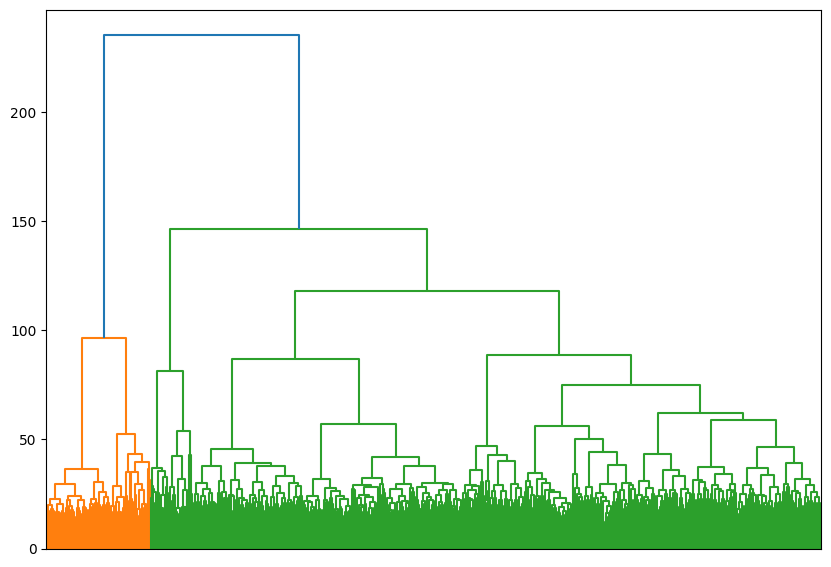

In [58]:
labelList = range(1, 11)

plt.figure(figsize=(10, 7))
dendrogram(linked,no_labels=True)
plt.show()

################################################################################################################################
################################################################################################################################

## 기능 1. 노래 입력 받아서 재생목록 추천

#### 노래 제목을 입력

#### 입력 : 아이유의 "Blumening"      

In [59]:
input = ["Blueming"]

#### 입력받은 노래가 보유하고 있는 데이터베이스 안에 있는지 확인합니다. 없는 경우 검색 조건을 완화 (feat 제거 등)하여 검색합니다.

In [60]:
input_lyrics = []
for i in input:
    try : 
        input_lyrics.append(train_data_all['가사'][train_data_all['제목']==i].values[0])
    except : 
        try : 
            # 검색 조건을 완화하여 검색
            print("입력한 제목과 정확히 일치하는 곡이 데이터베이스에 없습니다.")
            print("검색 조건을 완화하여 가사를 검색합니다.")
        except :
            print("입력한 제목과 일치하는 곡이 데이터베이스에 없습니다.")
            print("외부 데이터베이스에서 가사를 검색합니다.")

In [61]:
input_lyrics[0]

'‘뭐해?‘라는 두 글자에 ‘네가 보고 싶어’ 나의 속마음을 담아 우 이모티콘 하나하나 속에 달라지는 내 미묘한 심리를 알까 우  아니 바쁘지 않아 nothing no no 잠들어 있지 않아 insomnia nia nia 지금 다른 사람과 함께이지 않아 응, 나도 너를 생각 중  우리의 네모 칸은 bloom 엄지손가락으로 장미꽃을 피워 향기에 취할 것 같아 우 오직 둘만의 비밀의 정원  I feel bloom I feel bloom I feel bloom 너에게 한 송이를 더 보내  밤샘 작업으로 업데이트 흥미로운 이 작품의 지은이 that’s me 우 어쩜 이 관계의 클라이맥스 2막으로 넘어가기엔 지금이 good timing 우  같은 맘인 걸 알아 realize la lize 말을 고르지 말아 just reply la la ly 조금 장난스러운 나의 은유에 네 해석이 궁금해  우리의 색은 gray and blue 엄지손가락으로 말풍선을 띄워 금세 터질 것 같아 우 호흡이 가빠져 어지러워  I feel blue. I feel blue. I feel blue. 너에게 가득히 채워  띄어쓰기없이보낼게사랑인것같애 백만송이장미꽃을, 나랑피워볼래? 꽃잎의 색은 우리 마음 가는 대로 칠해 시들 때도 예쁘게  우리의 네모 칸은 bloom 엄지손가락으로 장미꽃을 피워 향기에 취할 것 같아 우 오직 둘만의 비밀의 정원  I feel bloom I feel bloom I feel bloom 너에게 한 송이를 더 보내'

In [62]:
input_lyrics_tokenized = []
for i in input_lyrics:
    temp_X = []
    temp_X = okt.morphs(i, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
input_lyrics_tokenized.append(temp_X)

In [63]:
input_lyrics_tokenized

[['‘',
  '뭐',
  '?',
  '‘',
  '라는',
  '두',
  '글자',
  '‘',
  '네',
  '보고',
  '싶다',
  '’',
  '나',
  '속마음',
  '을',
  '담다',
  '우',
  '이모티콘',
  '하나',
  '하나',
  '속',
  '달라지다',
  '내',
  '미묘하다',
  '심리',
  '알다',
  '우',
  '아니다',
  '바쁘다',
  '않다',
  'nothing',
  'no',
  'no',
  '잠들다',
  '있다',
  '않다',
  'insomnia',
  'nia',
  'nia',
  '지금',
  '다른',
  '사람과',
  '함께',
  '이지',
  '않다',
  '응',
  ',',
  '나다',
  '너',
  '생각',
  '중',
  '우리',
  '네모',
  '칸',
  'bloom',
  '엄지손가락',
  '장미꽃',
  '을',
  '피우다',
  '향기',
  '취할',
  '것',
  '같다',
  '우',
  '오직',
  '둘',
  '만의',
  '비밀',
  '정원',
  'I',
  'feel',
  'bloom',
  'I',
  'feel',
  'bloom',
  'I',
  'feel',
  'bloom',
  '너',
  '에게',
  '송이',
  '더',
  '보내다',
  '밤샘',
  '작업',
  '업데이트',
  '흥미롭다',
  '작품',
  '지은이',
  'that',
  '’',
  's',
  'me',
  '우',
  '어쩜',
  '관계',
  '클라이맥스',
  '2',
  '막',
  '넘어가다',
  '지금',
  'good',
  'timing',
  '우',
  '같다',
  '맘',
  '인',
  '걸',
  '알',
  '아',
  'realize',
  'la',
  'lize',
  '말',
  '을',
  '고르다',
  '말',
  '아',
  'just',
  'reply',
  'l

#### doc2vec 모델을 불러와 데이터베이스 내의 곡들과 유사도 비교를 실행합니다.

In [64]:
similarity_list = []
for text in input_lyrics_tokenized:
    inferred_v = model.infer_vector(text)
    print(f"vector of {text}: {inferred_v}")
    
    most_similar_docs = model.docvecs.most_similar([inferred_v], topn=5)
    for index, similarity in most_similar_docs:
        similarity_list.append(index)

vector of ['‘', '뭐', '?', '‘', '라는', '두', '글자', '‘', '네', '보고', '싶다', '’', '나', '속마음', '을', '담다', '우', '이모티콘', '하나', '하나', '속', '달라지다', '내', '미묘하다', '심리', '알다', '우', '아니다', '바쁘다', '않다', 'nothing', 'no', 'no', '잠들다', '있다', '않다', 'insomnia', 'nia', 'nia', '지금', '다른', '사람과', '함께', '이지', '않다', '응', ',', '나다', '너', '생각', '중', '우리', '네모', '칸', 'bloom', '엄지손가락', '장미꽃', '을', '피우다', '향기', '취할', '것', '같다', '우', '오직', '둘', '만의', '비밀', '정원', 'I', 'feel', 'bloom', 'I', 'feel', 'bloom', 'I', 'feel', 'bloom', '너', '에게', '송이', '더', '보내다', '밤샘', '작업', '업데이트', '흥미롭다', '작품', '지은이', 'that', '’', 's', 'me', '우', '어쩜', '관계', '클라이맥스', '2', '막', '넘어가다', '지금', 'good', 'timing', '우', '같다', '맘', '인', '걸', '알', '아', 'realize', 'la', 'lize', '말', '을', '고르다', '말', '아', 'just', 'reply', 'la', 'la', 'ly', '조금', '장난스럽다', '나', '은유', '네', '해석', '궁금하다', '우리', '색', 'gray', 'and', 'blue', '엄지손가락', '말풍선', '을', '띄우다', '금세', '터지다', '것', '같다', '우', '호흡', '가빠지다', '어지럽다', 'I', 'feel', 'blue', '.', 'I', 'feel', 'blue', '.', 'I', 

#### 각 곡이 속한 클러스터를 찾습니다.

In [65]:
similarity_cluster = []

cluster_find = -1
for each_song in similarity_list:
    for n, cluster in cluster_dict.items():
            try:
                if each_song in cluster[0]:
                    cluster_find = n
            except:
                break
    similarity_cluster.append(cluster_find)

In [66]:
cluster_cnt = [0,0,0,0,0,0,0,0,0,0]
for i in similarity_cluster:
    cluster_cnt[i] += 1

max = -1
max_n = -1
for n, i in enumerate(cluster_cnt):
    if i > max:
        max = i
        max_n = n

print(max_n)
     

9


#### 9번 클러스터에 속한 노래들 중 랜덤으로 추출된 곡을 선택하여 추천합니다.


In [67]:
songint = []
for i in range(10):
    num = random.randrange(len(cluster_dict[0]))
    while(num in songint):
        num = random.randrange(len(cluster_dict[0]))
    songint.append(train_data_all['제목'][num])

print(f"아이유의 'Blueming'를 좋아한다면 이 노래도 들어보세요! : {songint}")

아이유의 'Blueming'를 좋아한다면 이 노래도 들어보세요! : ['魂 (혼) (희철)', '사랑한다 외쳐요 (Feat. 미료 From 브라운 아이드 걸스)', 'Flying', 'My Girl', 'Fraktal Translates Oasis (Fraktal Desert Is Land Mix)', '어쩌다가', '어쩌다가', '멍청한 사랑', 'B 612', 'Good Life']


## 기능 1-2 : 가수 입력받아서 재생목록 추천

#### 가수(들)을 입력받습니다. 

##### EX 1) 입력값 : 방탄소년단

In [68]:
input2 = ["방탄소년단"]

In [69]:
for artist in input2:
    cnt = [0,0,0,0,0,0,0,0,0,0]
    for n, cluster in cluster_dict.items():
        for songs in cluster:
            if songs[0][1] == artist:
                cnt[n] += 1

print(cnt)

[268, 0, 0, 0, 0, 0, 0, 0, 0, 0]


#### 1번 클러스터에 속한 노래들 중 랜덤으로 추출된 곡을 선택합니다.

In [70]:
songint = []
for i in range(10):
    num = random.randrange(len(cluster_dict[0]))
    while(num in songint):
        num = random.randrange(len(cluster_dict[0]))
    songint.append(train_data_all['제목'][num])
print(f"가수 '방탄소년단'를 기반으로 추천해드릴 플레이리스트입니다 : {songint}")

가수 '방탄소년단'를 기반으로 추천해드릴 플레이리스트입니다 : ['소원이 있나요', '이젠', 'Phantom - 환영 (幻影)', '진실게임', '생일 축하곡 (Acid House Remix)', 'JoJo', 'Focus', 'Come 2 Me My Love', '슬픈 약속', '말해줄래']


##### EX 2) 입력값 : 아이유

In [71]:
input3 = ["아이유"]

#### 그 가수의 노래를 가장 많이 포함하고 있는 클러스터를 확인합니다.

In [72]:
for artist in input3:
    cnt = [0,0,0,0,0,0,0,0,0,0]
    for n, cluster in cluster_dict.items():
        for songs in cluster:
            if songs[0][1] == artist:
                cnt[n] += 1

print(cnt)

[0, 0, 0, 0, 41, 0, 0, 0, 0, 0]


#### 5번 클러스터에 속한 노래들 중 랜덤으로 추출된 곡을 선택합니다.

In [73]:
songint = []
for i in range(10):
    num = random.randrange(len(cluster_dict[0]))
    while(num in songint):
        num = random.randrange(len(cluster_dict[0]))
    songint.append(train_data_all['제목'][num])
print(f"가수 '아이유'를 기반으로 추천해드릴 플레이리스트입니다 : {songint}")

가수 '아이유'를 기반으로 추천해드릴 플레이리스트입니다 : ['Come Back To Me', 'Real', '어제와 다른 오늘', '상상속의 너', 'B612', '여성시대', '슬픈 기적', 'Watch Out', '경고 (Remix Ver.)', 'Bang Bang Boom！']
